# Two port electrical parameters
For two port electrical systems there are a family of related parameters to characterize the system. For radio-frequency applications s-parameters are a common choice to indicate the electrical response of the system. This family of electrical parameters are chosen based on what type of analysis is required, they effectively encode much of the same information so that they may be interchanged in many instances. 
1. S-parameters
2. Z-parameters
3. Y-parameters
4. T-parameters
5. ABCD-parameters
6. H-parameters

## Creating a graph that connects the parameters. 
As can be seen a set of parameters may be chosen based on the analysis needed, by creating a "content" graph we can have any set of parameters given one set. To do this we must first determine which information is required.

## Basic data model
Each of the parameters for the two-port can be represented by a matrix, each of these matrix representations are frequency dependent. This lends it self to a data model that is a python list [[fi,m11,m12,m21,m22],...  or a list of matrices with a frequency list. [[f,matrix()]..], if a matrix determinant of inverse is required then use matrix form otherwise use the list form. The port and load impedance must be specified to use all of the transforms and frequency units should be specified.

In [1]:
import numpy as np
from pyMeasure import *
from pyMeasure.Code.DataHandlers.GraphModels import *

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [2]:
# first we define matrix to list conversions
def FrequencyList_to_FrequencyMatrixList(frequency_list):
    """Converts a list of form [f,m11,m12,m21,m22] to a list of form [f,np.matrix([[m11,m12],[m12,m22]])]
    inverse of FrequencyMatrixList_to_FrequencyList """
    matrix_list=[]
    for row in frequency_list[:]:
        frequency=row[0]
        [m11,m12,m21,m22]=row[1:]
        matrix=np.matrix([[m11,m12],[m21,m22]])
        matrix_list.append([frequency,matrix])
    return matrix_list

def FrequencyMatrixList_to_FrequencyList(frequency_matrix_list):
    """Converts a list of form [f,np.matrix([[m11,m12],[m12,m22]])] to a list of form [f,m11,m12,m21,m22]
    inverse of FrequencyList_to_FrequencyMatrixList"""
    frequency_list=[]
    for row in frequency_matrix_list[:]:
        frequency=row[0]
        matrix=row[1]
        [m11,m12,m21,m22]=[matrix[0,0],matrix[0,1],matrix[1,0],matrix[1,1]]
        frequency_list.append([frequency,m11,m12,m21,m22])
    return frequency_list

# now for each set of parameters we need a single conversion into and out of the format

# This was copied and needs to be refactored to be consitent with the other tranforms
def SFrequencyMatrixList_to_TFrequencyMatrixList(s_frequency_matrix_list):
    """Converts S-parameters into a T Matrix. Input form should be in frequency, np.matrix([[S11,S12],[S21,S22]])
    format. Returns a list in [frequency, np.matrix] format.
    Is the inverse of TFrequencyMatrixList_to_SFrequencyMatrixList"""
    t_frequency_matrix_list=[]
    for row in s_frequency_matrix_list:
        frequency=row[0]
        m=row[1]
        T11=-np.linalg.det(m)/m[1,0]
        T12=m[0,0]/m[1,0]
        T21=-m[1,1]/m[1,0]
        T22=1/m[1,0]
        t_frequency_matrix_list.append([frequency,np.matrix([[T11,T12],[T21,T22]])])
    return t_frequency_matrix_list

def TFrequencyMatrixList_to_SFrequencyMatrixList(t_frequency_matrix_list):
    """Converts T Matrix into S parameters. Input form should be in frequency, np.matrix([[T11,T12],[T21,T22]])
    format. Returns a list in [frequency, np.matrix] format. 
    Is the inverse of SFrequencyMatrixList_to_TFrequencyMatrixList"""
    s_frequency_matrix_list=[]
    for row in t_frequency_matrix_list:
        frequency=row[0]
        m=row[1]
        S11=m[0,1]/m[1,1]
        S12=np.linalg.det(m)/m[1,1]
        S21=1/m[1,1]
        S22=-m[1,0]/m[1,1]
        s_frequency_matrix_list.append([frequency,np.matrix([[S11,S12],[S21,S22]])])
    return s_frequency_matrix_list

def SFrequencyList_to_ZFrequencyList(s_frequency_list,Z01=complex(50,0),Z02=complex(50,0)):
    """ Converts s parameters into z-parameters. S-parameters should be in the form [[f,S11,S12,S21,S22],...]
    the port 1 (Z01) and port 2 (Z01) impedances can be specified, default is 50. Returns data in the form
    [[f,Z11,Z12,Z21,Z22],...]
    """
    z_frequency_list=[]
    for row in s_frequency_list[:]:
        [frequency,S11,S12,S21,S22]=row
        denominator=-1*((1-S11)*(1-S22)-S12*S21)
        Z11=((Z01.conjugate()+S11*Z01)*(1-S22)+S12*S21*Z01)/denominator
        Z12=(2*S12*(Z01.real*Z02.real)**(.5))/denominator
        Z21=(2*S21*(Z01.real*Z02.real)**(.5))/denominator
        Z22=((1-S11)*(Z02.conjugate()+S22*Z02)+S21*S12*Z02)/denominator
        z_frequency_list.append([frequency,complex(abs(Z11.real),Z11.imag),Z12,Z21,complex(abs(Z22.real),Z22.imag)])
    return z_frequency_list

def SFrequencyMatrixList_to_ZFrequencyMatrixList(s_frequency_matrix_list,Z01=complex(50,0),Z02=complex(50,0)):
    """ Converts s parameters into z-parameters. S-parameters should be in the form 
    [[f,np.matrix([[S11,S12],S21,S22]],...]
    the port 1 (Z01) and port 2 (Z01) impedances can be specified, default is 50. Returns data in the form
    [[f,np.matrix([[Z11,Z12],[Z21,Z22]]),...]
    """
    z_frequency_matrix_list=[]
    for row in s_frequency_matrix_list[:]:
        [frequency,m]=row
        [S11,S12,S21,S22]=[m[0,0],m[0,1],m[1,0],m[1,1]]
        denominator=-1*((1-S11)*(1-S22)-S12*S21)
        Z11=((Z01.conjugate()+S11*Z01)*(1-S22)+S12*S21*Z01)/denominator
        Z12=(2*S12*(Z01.real*Z02.real)**(.5))/denominator
        Z21=(2*S21*(Z01.real*Z02.real)**(.5))/denominator
        Z22=((1-S11)*(Z02.conjugate()+S22*Z02)+S21*S12*Z02)/denominator
        z_frequency_matrix_list.append([frequency,
                                        np.matrix([[complex(abs(Z11.real),Z11.imag),Z12],
                                                   [Z21,complex(abs(Z22.real),Z22.imag)]])])
    return z_frequency_matrix_list


def ZFrequencyList_to_TFrequencyList(Z_frequency_list,Z01=complex(50,0),Z02=complex(50,0)):
    """ Converts z parameters into T parameters. Z-parameters should be in the form [[f,Z11,Z12,Z21,Z22],...]
    the port 1 (Z01) and port 2 (Z01) impedances can be specified, default is 50. Returns data in the form
    [[f,T11,T12,T21,T22],...]
    """  
    t_frequency_list=[]
    for row in Z_frequency_list[:]:
        [frequency,Z11,Z12,Z21,Z22]=row
        denominator=2*Z21*(Z01.real*Z02.real)**(.5)
        T11= ((Z11+Z01)*(Z22+Z02)-Z12*Z21)/denominator
        T12=((Z11+Z01)*(Z02.conjugate()-Z22)+Z12*Z21)/denominator
        T21=((Z11-Z01.conjugate())*(Z22+Z02)-Z12*Z21)/denominator
        T22=((Z01.conjugate()-Z11)*(Z22-Z02.conjugate())+Z12*Z21)/denominator
        t_frequency_list.append([frequency,T11,T12,T21,T22])
    return t_frequency_list
                                        
def ZFrequencyMatrixList_to_TFrequencyMatrixList(Z_frequency_matrix_list,Z01=complex(50,0),Z02=complex(50,0)):
    """ Converts z parameters into T parameters. Z-parameters should be in the form [[f,np.matrix([[Z11,Z12],[Z21,Z22]])],...]
    the port 1 (Z01) and port 2 (Z01) impedances can be specified, default is 50. Returns data in the form
    [[f,np.matrix([[T11,T12],[T21,T22]])],...]
    """  
    t_frequency_matrix_list=[]
    for row in Z_frequency_matrix_list[:]:
        [frequency,m]=row
        [Z11,Z12,Z21,Z22]=[m[0,0],m[0,1],m[1,0],m[1,1]]                                
        denominator=2*Z21*(Z01.real*Z02.real)**(.5)
        T11= ((Z11+Z01)*(Z22+Z02)-Z12*Z21)/denominator
        T12=((Z11+Z01)*(Z02.conjugate()-Z22)+Z12*Z21)/denominator
        T21=((Z11-Z01.conjugate())*(Z22+Z02)-Z12*Z21)/denominator
        T22=((Z01.conjugate()-Z11)*(Z22-Z02.conjugate())+Z12*Z21)/denominator
        t_frequency_matrix_list.append([frequency,np.matrix([[T11,T12],[T21,T22]])])
    return t_frequency_matrix_list 


def ABCDFrequencyList_to_YFrequencyList(ABCD_frequency_list):
    """ Converts ABCD parameters into Y-parameters. ABCD-parameters should be in the form [[f,A,B,C,D],...]
    Returns data in the form
    [[f,Y11,Y12,Y21,Y22],...]
    """  
    y_frequency_list=[]
    for row in ABCD_frequency_list[:]:
        [frequency,A,B,C,D]=row
        Y11=D/B
        Y12=(B*C-A*D)/B
        Y21=-1/B
        Y22=A/B
        y_frequency_list.append([frequency,Y11,Y12,Y21,Y22])
    return y_frequency_list 

def YFrequencyList_to_HFrequencyList(y_frequency_list):
    """ Converts Y parameters into h-parameters. ABCD-parameters should be in the form [[f,Y11,Y12,Y21,Y22],...]
    Returns data in the form
    [[f,h11,h12,h21,h22],...]
    """  
    h_frequency_list=[]
    for row in y_frequency_list[:]:
        [frequency,Y11,Y12,Y21,Y22]=row
        h11=1/Y11
        h12=-1*Y12/Y11
        h21=Y21/Y11
        h22=(Y11*Y22-Y12*Y21)/Y11
        h_frequency_list.append([frequency,h11,h12,h21,h22])
    return h_frequency_list 

def ABCDFrequencyList_to_HFrequencyList(ABCD_frequency_list):
    """ Converts ABCD parameters into h-parameters. ABCD-parameters should be in the form [[f,A,B,C,D],...]
    Returns data in the form
    [[f,h11,h12,h21,h22],...]
    """  
    h_frequency_list=[]
    for row in ABCD_frequency_list[:]:
        [frequency,A,B,C,D]=row
        h11=B/D
        h12=(A*D-B*C)/D
        h21=-1/D
        h22=C/D
        h_frequency_list.append([frequency,h11,h12,h21,h22])
    return h_frequency_list    

def HFrequencyList_to_ZFrequencyList(h_frequency_list):
    """ Converts h parameters into Z-parameters. h-parameters should be in the form [[f,h11,h12,h21,h22],...]
    Returns data in the form
    [[f,Z11,Z12,Z21,Z22],...]
    """  
    z_frequency_list=[]
    for row in h_frequency_list[:]:
        [frequency,h11,h12,h21,h22]=row
        Z11=(h11*h22-h12*h21)/h22
        Z12=h12/h22
        Z21=-1*h21/h22
        Z22=1/h22
        z_frequency_list.append([frequency,Z11,complex(abs(Z12.real),Z12.imag),complex(abs(Z21.real),Z21.imag),Z22])
    return z_frequency_list 

def ZFrequencyMatrixList_to_YFrequencyMatrixList(z_frequency_matrix_list):
    """ Converts Z parameters into Y-parameters. Z-parameters should be in the form 
    [[f,np.matrix([[Z11,Z12],[Z21,Z22]])],...]
    Returns data in the form
    [[f,np.matrix([[Y11,Y12],[Y21,Y22]])],...]
    inverse of YFrequencyMatrixList_to_ZFrequencyMatrixList
    """  
    y_frequency_matrix_list=[]
    for row in z_frequency_matrix_list[:]:
        frequency=row[0]
        m=row[1]
        y_frequency_matrix_list.append([frequency,m.I])
    return y_frequency_matrix_list
                                        
def YFrequencyMatrixList_to_ZFrequencyMatrixList(y_frequency_matrix_list):
    """ Converts Z parameters into Y-parameters. Z-parameters should be in the form 
    [[f,np.matrix([[Y11,Y12],[Y21,Y22]])],...]
    Returns data in the form
    [[f,np.matrix([[Z11,Z12],[Z21,Z22]])],...]
    inverse of ZFrequencyMatrixList_to_YFrequencyMatrixList
    """  
    z_frequency_matrix_list=[]
    for row in y_frequency_matrix_list[:]:
        frequency=row[0]
        m=row[1]
        z_frequency_matrix_list.append([frequency,m.I])
    return z_frequency_matrix_list

def ZFrequencyList_to_ABCDFrequencyList(z_frequency_list):
    """ Converts z parameters into ABCD-parameters. Z-parameters should be in the form [[f,Z11,Z12,Z21,Z22],...]
    Returns data in the form
    [[f,A,B,C,D],...]
    inverse of ABCDFrequencyList_to_ZFrequencyList
    """  
    ABCD_frequency_list=[]
    for row in z_frequency_list[:]:
        [frequency,Z11,Z12,Z21,Z22]=row
        A=Z11/Z21
        B=(Z11*Z22-Z12*Z21)/Z21
        C=1/Z21
        D=Z22/Z21
        ABCD_frequency_list.append([frequency,A,B,C,D])
    return ABCD_frequency_list   

def ABCDFrequencyList_to_ZFrequencyList(ABCD_frequency_list):
    """ Converts ABCD parameters into z-parameters. ABCD-parameters should be in the form [[f,A,B,C,D],...]
    Returns data in the form
    [[f,Z11,Z12,Z21,Z22],...], 
    inverse of ZFrequencyList_to_ABCDFrequencyList
    """  
    z_frequency_list=[]
    for row in ABCD_frequency_list[:]:
        [frequency,A,B,C,D]=row
        Z11=A/C
        Z12=(A*D-B*C)/C
        Z21=1/C
        Z22=D/C
        z_frequency_list.append([frequency,complex(abs(Z11.real),Z11.imag),Z12,Z21,complex(abs(Z22.real),Z22.imag)])
    return z_frequency_list

def ABCDFrequencyList_to_SFrequencyList(ABCD_frequency_list,Z01=complex(50,0),Z02=complex(50,0)):
    """ Converts ABCD parameters into s-parameters. ABCD-parameters should be in the form [[f,A,B,C,D],...]
    Returns data in the form
    [[f,S11,S12,S21,S22],...], 
    """  
    s_frequency_list=[]
    for row in ABCD_frequency_list[:]:
        [frequency,A,B,C,D]=row
        denominator=A*Z02+B+C*Z01*Z02+D*Z01
        S11=(A*Z02+B-C*Z01.conjugate()*Z02-D*Z01.conjugate())/denominator
        S12=-1*(2*(Z01.real*Z02.real)**(.5))/denominator
        S21=-1*(2*(Z01.real*Z02.real)**(.5))/denominator
        S22=(-1*A*Z02.conjugate()+B-C*Z01*Z02+D*Z01)/denominator
        s_frequency_list.append([frequency,S11,S12,S21,S22])
    return s_frequency_list

## Creating a content graph for the parameters
1. Begin with SParameterFrequencyList <-> SParameterFrequencyMatrixList
2. Add SParameterFrequencyMatrixList <-> TParameterFrequencyMatrixList
3. Add TParameterFrequencyMatrixList <-> TParameterFrequencyList
4. Add SParameterFrequencyList -> ZParameterFrequencyList and ZParameterFrequencyList -> TParameterFrequencyList
5. Add ZParameterFrequencyList <-> ZParameterFrequencyMatrixList
6. Add SParameterFrequencyList -> ABCDParameterFrequencyList and ABCDParameterFrequencyList -> TParameterFrequencyList
7. Add ABCDParameterFrequencyList <-> ABCDParameterFrequencyMatrixList
8. Add ABCDParameterFrequencyList -> HParameterFrequencyList and HParameterFrequencyList -> ZParameterFrequencyList
9. Add HParameterFrequencyList <-> HParameterFrequencyMatrixList
10. Add ABCDParameterFrequencyList -> YParameterFrequencyList and YParameterFrequencyList -> HParameterFrequencyList
11. Add YParameterFrequencyList <-> YParameterFrequencyMatrixList




In [3]:
# We begin with the basic graph setup 
S11=.9
S21=(1-S11**2)**.5
graph_options={"graph_name":"Two Port Parameter Graph",
                  "node_names":["SFrequencyList",'SFrequencyMatrixList'],
                  "node_descriptions":["S Parameters","S Parameters in a Matrix"],
                  "current_node":'SFrequencyList',
                  "state":[1,0],
                  "data":[[1.0,S11,S21,S21,S11]],
                  "edge_2_to_1":FrequencyMatrixList_to_FrequencyList,
                  "edge_1_to_2":FrequencyList_to_FrequencyMatrixList,
                  "frequency_units":"GHz",
                  "Z01":50,
                  "Z02":50 }
two_port_parameter_graph=Graph(**graph_options)

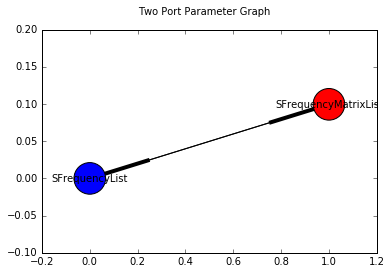

In [4]:
%matplotlib inline
two_port_parameter_graph.show()

In [5]:
# now we add the nodes
two_port_parameter_graph.add_node("TFrequencyMatrixList",
                                  "SFrequencyMatrixList",SFrequencyMatrixList_to_TFrequencyMatrixList,
                                  "SFrequencyMatrixList",TFrequencyMatrixList_to_SFrequencyMatrixList,
                                  "T Parameters in a Matrix")

two_port_parameter_graph.add_node("TFrequencyList",
                                  "TFrequencyMatrixList",FrequencyMatrixList_to_FrequencyList,
                                  "TFrequencyMatrixList",FrequencyList_to_FrequencyMatrixList,
                                  "T Parameters")

two_port_parameter_graph.add_node("ZFrequencyList",
                                  "SFrequencyList",SFrequencyList_to_ZFrequencyList,
                                  "TFrequencyList",ZFrequencyList_to_TFrequencyList,
                                  "Z Parameters")

two_port_parameter_graph.add_node("ZFrequencyMatrixList",
                                  "ZFrequencyList",FrequencyList_to_FrequencyMatrixList,
                                  "ZFrequencyList",FrequencyMatrixList_to_FrequencyList,
                                  "Z Parameters in a matrix")

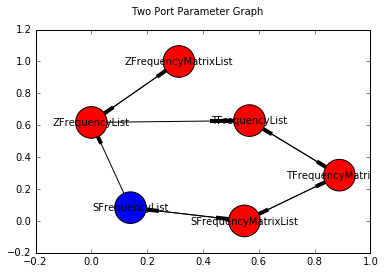

In [6]:
%matplotlib inline
two_port_parameter_graph.show()

In [7]:
two_port_parameter_graph.data

[[1.0, 0.9, 0.4358898943540673, 0.4358898943540673, 0.9]]

['edge_SFrequencyList_SFrequencyMatrixList_000', 'edge_SFrequencyMatrixList_TFrequencyMatrixList_000']
moving SFrequencyList -> SFrequencyMatrixList
moving SFrequencyMatrixList -> TFrequencyMatrixList
[[1.0, matrix([[-1.42237755,  2.0647416 ],
        [-2.0647416 ,  2.29415734]])]]


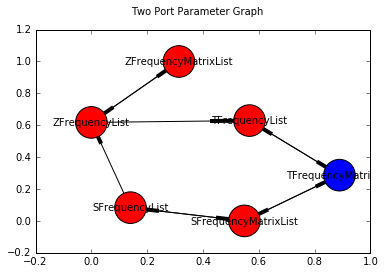

In [8]:
two_port_parameter_graph.move_to_node("TFrequencyMatrixList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [9]:
two_port_parameter_graph.move_to_node("SFrequencyMatrixList")
print(two_port_parameter_graph.data)

['edge_TFrequencyMatrixList_SFrequencyMatrixList_000']
moving TFrequencyMatrixList -> SFrequencyMatrixList
[[1.0, matrix([[ 0.9       ,  0.43588989],
        [ 0.43588989,  0.9       ]])]]


['edge_SFrequencyMatrixList_SFrequencyList_000', 'edge_SFrequencyList_ZFrequencyList_000']
moving SFrequencyMatrixList -> SFrequencyList
moving SFrequencyList -> ZFrequencyList
[[1.0, (105.55555555555547+0j), 242.16105241892635, 242.1610524189262, (105.55555555555547+0j)]]


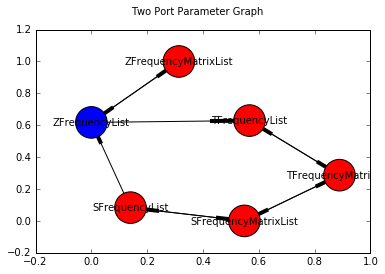

In [10]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [11]:
two_port_parameter_graph.move_to_node("SFrequencyMatrixList")
print(two_port_parameter_graph.data)

equality_list is [True, False, True, False, False]
equality_list is [True, False, True, False, False]
['edge_ZFrequencyList_TFrequencyList_000', 'edge_TFrequencyList_TFrequencyMatrixList_000', 'edge_TFrequencyMatrixList_SFrequencyMatrixList_000']
moving ZFrequencyList -> TFrequencyList
moving TFrequencyList -> TFrequencyMatrixList
moving TFrequencyMatrixList -> SFrequencyMatrixList
[[1.0, matrix([[ 0.90000000+0.j,  0.43588989+0.j],
        [ 0.43588989+0.j,  0.90000000-0.j]])]]


In [12]:
z=[[1,50,10000,10000,50]]
two_port_parameter_graph.set_state("ZFrequencyList",z)

equality_list is [True, False, True, False, False, False]
equality_list is [True, False, True, False, False, False]
['edge_ZFrequencyList_TFrequencyList_000', 'edge_TFrequencyList_TFrequencyMatrixList_000', 'edge_TFrequencyMatrixList_SFrequencyMatrixList_000', 'edge_SFrequencyMatrixList_SFrequencyList_000']
moving ZFrequencyList -> TFrequencyList
moving TFrequencyList -> TFrequencyMatrixList
moving TFrequencyMatrixList -> SFrequencyMatrixList
moving SFrequencyMatrixList -> SFrequencyList
[[1, (1+0j), (0.010000000000005116+0j), (0.01+0j), (1-0j)]]


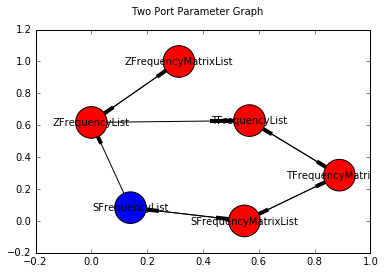

In [13]:
two_port_parameter_graph.move_to_node("SFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_SFrequencyList_ZFrequencyList_000']
moving SFrequencyList -> ZFrequencyList
[[1, (49.99999999999999+0j), (9999.9999999999982+0j), (9999.9999999948832+0j), (49.99999999999999+0j)]]


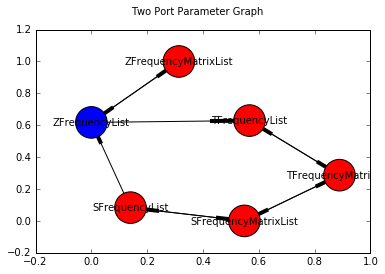

In [14]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [15]:
two_port_parameter_graph.add_node("ABCDFrequencyList",
                                  "ZFrequencyList",ZFrequencyList_to_ABCDFrequencyList,
                                  "ZFrequencyList",ABCDFrequencyList_to_ZFrequencyList,
                                  "ABCD Parameters")

two_port_parameter_graph.add_node("ABCDFrequencyMatrixList",
                                  "ABCDFrequencyList",FrequencyList_to_FrequencyMatrixList,
                                  "ABCDFrequencyList",FrequencyMatrixList_to_FrequencyList,
                                  "ABCD Parameters in a matrix")

['edge_ZFrequencyList_ABCDFrequencyList_000']
moving ZFrequencyList -> ABCDFrequencyList
[[1, (0.005000000000002558+0j), (-9999.7499999999982+0j), (0.00010000000000005117+0j), (0.005000000000002558+0j)]]


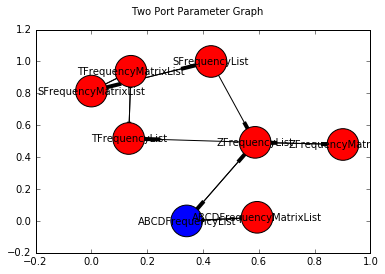

In [16]:
two_port_parameter_graph.move_to_node("ABCDFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_ABCDFrequencyList_ZFrequencyList_000']
moving ABCDFrequencyList -> ZFrequencyList
[[1, (49.99999999999999+0j), (9999.9999999999964+0j), (9999.9999999948832+0j), (49.99999999999999+0j)]]


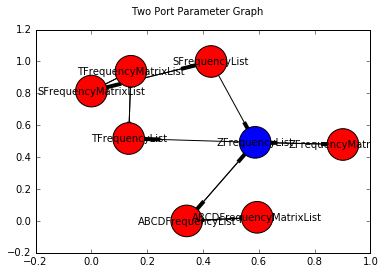

In [17]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [18]:
two_port_parameter_graph.add_node("HFrequencyList",
                                  "ABCDFrequencyList",ABCDFrequencyList_to_HFrequencyList,
                                  "ZFrequencyList",HFrequencyList_to_ZFrequencyList,
                                  "h Parameters")

two_port_parameter_graph.add_node("HFrequencyMatrixList",
                                  "HFrequencyList",FrequencyList_to_FrequencyMatrixList,
                                  "HFrequencyList",FrequencyMatrixList_to_FrequencyList,
                                  "H Parameters in a matrix")



['edge_ZFrequencyList_ABCDFrequencyList_000', 'edge_ABCDFrequencyList_HFrequencyList_000']
moving ZFrequencyList -> ABCDFrequencyList
moving ABCDFrequencyList -> HFrequencyList
[[1, (-1999949.999998976+0j), (199.99999999999994+0j), (-199.99999999989768+0j), (0.02+0j)]]


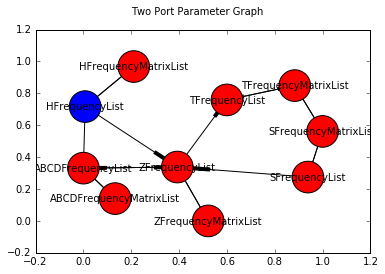

In [19]:
two_port_parameter_graph.move_to_node("HFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_HFrequencyList_ZFrequencyList_000']
moving HFrequencyList -> ZFrequencyList
[[1, (50.000000000363798+0j), (9999.999999999996+0j), (9999.999999994885-0j), (50+0j)]]


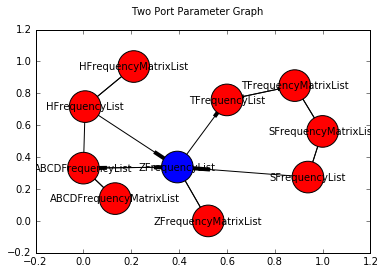

In [20]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [21]:

two_port_parameter_graph.add_node("YFrequencyList",
                                  "ABCDFrequencyList",ABCDFrequencyList_to_YFrequencyList,
                                  "HFrequencyList",YFrequencyList_to_HFrequencyList,
                                  "Y Parameters")

two_port_parameter_graph.add_node("YFrequencyMatrixList",
                                  "YFrequencyList",FrequencyList_to_FrequencyMatrixList,
                                  "YFrequencyList",FrequencyMatrixList_to_FrequencyList,
                                  "Y Parameters in a matrix")

['edge_ZFrequencyList_ABCDFrequencyList_000', 'edge_ABCDFrequencyList_YFrequencyList_000']
moving ZFrequencyList -> ABCDFrequencyList
moving ABCDFrequencyList -> YFrequencyList
[[1, (-5.0001250031276385e-07-0j), (0.00010000250006255274-0j), (0.00010000250006250162-0j), (-5.0001250031640196e-07-0j)]]


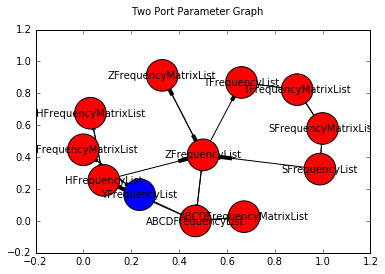

In [22]:
two_port_parameter_graph.move_to_node("YFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

equality_list is [True, False, True, False, False]
equality_list is [True, False, True, False, False]
['edge_YFrequencyList_HFrequencyList_000', 'edge_HFrequencyList_ZFrequencyList_000', 'edge_ZFrequencyList_TFrequencyList_000']
moving YFrequencyList -> HFrequencyList
moving HFrequencyList -> ZFrequencyList
moving ZFrequencyList -> TFrequencyList
[[1, (-99.989999999999895+0j), (99.999999999999972+0j), (-99.999999999999901+0j), (99.999999999999972+0j)]]


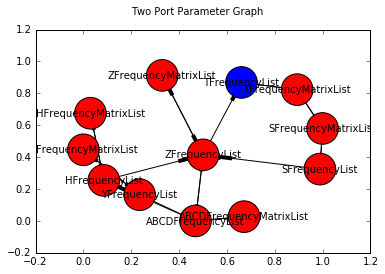

In [23]:
two_port_parameter_graph.move_to_node("TFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_TFrequencyList_TFrequencyMatrixList_000', 'edge_TFrequencyMatrixList_SFrequencyMatrixList_000', 'edge_SFrequencyMatrixList_SFrequencyList_000', 'edge_SFrequencyList_ZFrequencyList_000']
moving TFrequencyList -> TFrequencyMatrixList
moving TFrequencyMatrixList -> SFrequencyMatrixList
moving SFrequencyMatrixList -> SFrequencyList
moving SFrequencyList -> ZFrequencyList
[[1, (50.000000000666134+0j), (9999.9999999999964+0j), (9999.9999999948977+0j), (50+0j)]]


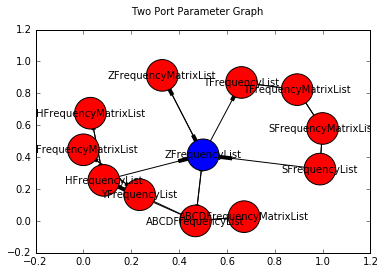

In [24]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_ZFrequencyList_ABCDFrequencyList_000']
moving ZFrequencyList -> ABCDFrequencyList
[[1, (0.0050000000000691644+0j), (-9999.7499999999927+0j), (0.00010000000000005102+0j), (0.005000000000002551+0j)]]


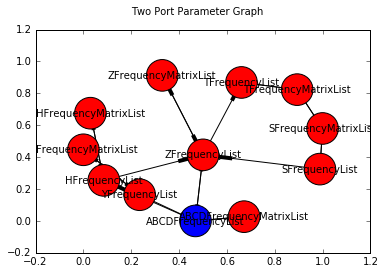

In [25]:
two_port_parameter_graph.move_to_node("ABCDFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_ABCDFrequencyList_ZFrequencyList_000']
moving ABCDFrequencyList -> ZFrequencyList
[[1, (50.000000000666134+0j), (9999.9999999999964+0j), (9999.9999999948977+0j), (50+0j)]]


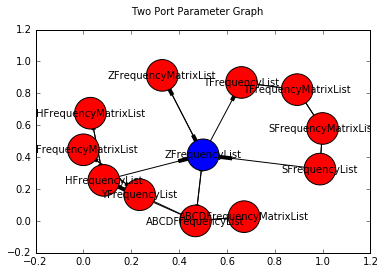

In [26]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

equality_list is [True, False, False, False, False, False, False, False, True, False, True, False, False, False]
equality_list is [False, False, True, False, True, False, False, False, False, False, False, False, False, False]
equality_list is [False, False, True, False, True, False, False, False, False, False, False, False, False, False]
equality_list is [False, False, False, False, False, True, False, True, False, False, False, False, False, False]
equality_list is [False, False, False, False, False, True, False, True, False, False, False, False, False, False]
equality_list is [True, False, False, False, False, False, False, False, True, False, True, False, False, False]
equality_list is [True, False, False, False, False, False, False, False, True, False, True, False, False, False]
['edge_ZFrequencyList_TFrequencyList_000', 'edge_TFrequencyList_TFrequencyMatrixList_000', 'edge_TFrequencyMatrixList_SFrequencyMatrixList_000', 'edge_SFrequencyMatrixList_SFrequencyList_000']
moving ZFreq

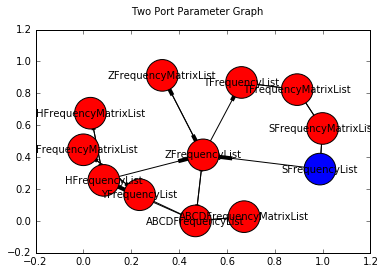

In [27]:
two_port_parameter_graph.move_to_node("SFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_SFrequencyList_ZFrequencyList_000', 'edge_ZFrequencyList_ABCDFrequencyList_000', 'edge_ABCDFrequencyList_HFrequencyList_000']
moving SFrequencyList -> ZFrequencyList
moving ZFrequencyList -> ABCDFrequencyList
moving ABCDFrequencyList -> HFrequencyList
[[1, (-1999949.9999945371+0j), (199.9999999995558+0j), (-199.99999999945388+0j), (0.019999999999955591+0j)]]


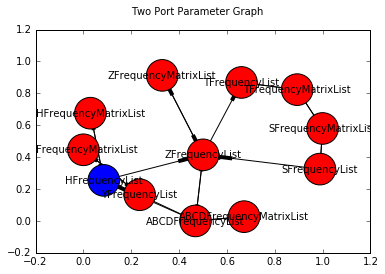

In [28]:
two_port_parameter_graph.move_to_node("HFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_HFrequencyList_ZFrequencyList_000']
moving HFrequencyList -> ZFrequencyList
[[1, (50.00000000047482+0j), (9999.999999999995+0j), (9999.999999994898-0j), (50.000000000111022+0j)]]


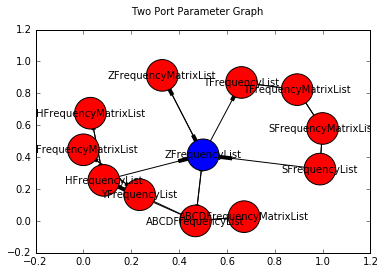

In [29]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [30]:
two_port_parameter_graph.add_edge(begin_node="ZFrequencyMatrixList",
                                  end_node="YFrequencyMatrixList",
                                  edge_function=ZFrequencyMatrixList_to_YFrequencyMatrixList)
# two_port_parameter_graph.add_edge(begin_node="YFrequencyMatrixList",
#                                   end_node="ZFrequencyMatrixList",
#                                   edge_function=YFrequencyMatrixList_to_ZFrequencyMatrixList)
two_port_parameter_graph.add_edge(begin_node="SFrequencyMatrixList",
                                  end_node="ZFrequencyMatrixList",
                                  edge_function=SFrequencyMatrixList_to_ZFrequencyMatrixList)
two_port_parameter_graph.add_edge(begin_node="ZFrequencyMatrixList",
                                  end_node="TFrequencyMatrixList",
                                  edge_function=ZFrequencyMatrixList_to_TFrequencyMatrixList)
two_port_parameter_graph.add_edge(begin_node="ABCDFrequencyList",
                                  end_node="SFrequencyList",
                                  edge_function=ABCDFrequencyList_to_SFrequencyList)


['edge_ZFrequencyList_ZFrequencyMatrixList_000', 'edge_ZFrequencyMatrixList_YFrequencyMatrixList_000']
moving ZFrequencyList -> ZFrequencyMatrixList
moving ZFrequencyMatrixList -> YFrequencyMatrixList
[[1, matrix([[ -5.00012500e-07-0.j,   1.00002500e-04+0.j],
        [  1.00002500e-04+0.j,  -5.00012500e-07+0.j]])]]


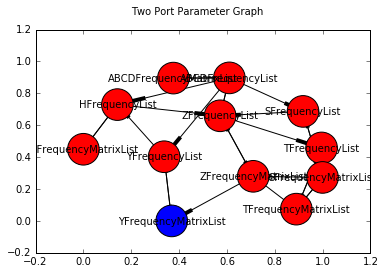

In [31]:
two_port_parameter_graph.move_to_node("YFrequencyMatrixList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

['edge_YFrequencyMatrixList_YFrequencyList_000', 'edge_YFrequencyList_HFrequencyList_000', 'edge_HFrequencyList_ZFrequencyList_000']
moving YFrequencyMatrixList -> YFrequencyList
moving YFrequencyList -> HFrequencyList
moving HFrequencyList -> ZFrequencyList
[[1, (50.00000000047482+0j), (9999.999999999993+0j), (9999.999999994898+0j), (50.000000000111022+0j)]]


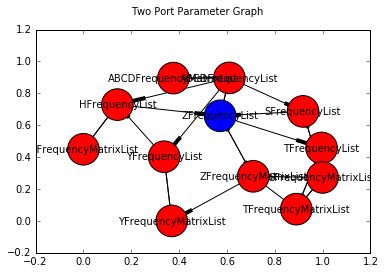

In [32]:
two_port_parameter_graph.move_to_node("ZFrequencyList")
print(two_port_parameter_graph.data)
two_port_parameter_graph.show()

In [33]:
# now we need to visit all of the nodes
two_port_parameter_graph.is_graph_isomorphic()

['edge_ZFrequencyList_ABCDFrequencyList_000', 'edge_ABCDFrequencyList_SFrequencyList_000']
moving ZFrequencyList -> ABCDFrequencyList
moving ABCDFrequencyList -> SFrequencyList
['edge_SFrequencyList_SFrequencyMatrixList_000']
moving SFrequencyList -> SFrequencyMatrixList
['edge_SFrequencyMatrixList_TFrequencyMatrixList_000']
moving SFrequencyMatrixList -> TFrequencyMatrixList
['edge_TFrequencyMatrixList_TFrequencyList_000']
moving TFrequencyMatrixList -> TFrequencyList
['edge_TFrequencyList_TFrequencyMatrixList_000', 'edge_TFrequencyMatrixList_SFrequencyMatrixList_000', 'edge_SFrequencyMatrixList_SFrequencyList_000', 'edge_SFrequencyList_ZFrequencyList_000']
moving TFrequencyList -> TFrequencyMatrixList
moving TFrequencyMatrixList -> SFrequencyMatrixList
moving SFrequencyMatrixList -> SFrequencyList
moving SFrequencyList -> ZFrequencyList
['edge_ZFrequencyList_ZFrequencyMatrixList_000']
moving ZFrequencyList -> ZFrequencyMatrixList
['edge_ZFrequencyMatrixList_ZFrequencyList_000', 'edge

True

In [34]:
from ipywidgets import *
def move_and_show(node,graph=two_port_parameter_graph):
    graph.move_to_node(node)
    print(graph.data)
    graph.show()

['edge_ZFrequencyList_ABCDFrequencyList_000', 'edge_ABCDFrequencyList_SFrequencyList_000']
moving ZFrequencyList -> ABCDFrequencyList
moving ABCDFrequencyList -> SFrequencyList
[[1, (1-0j), (0.01-0j), (0.01-0j), (1-0j)]]


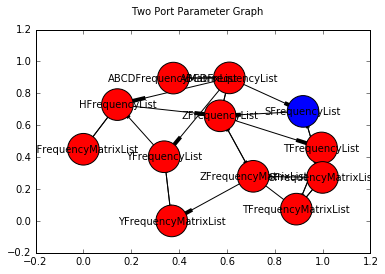

<function __main__.<lambda>>

In [35]:
z=[[1,50,10000,10000,50]]
two_port_parameter_graph.set_state("ZFrequencyList",z)
interact(lambda node_name:move_and_show(node_name,two_port_parameter_graph),node_name=two_port_parameter_graph.node_names)

In [36]:
two_port_parameter_graph.get_path("YFrequencyMatrixList","SFrequencyList")

equality_list is [False, False, True, False, True, False, False]
equality_list is [False, False, True, False, True, False, False]


['edge_YFrequencyMatrixList_YFrequencyList_000',
 'edge_YFrequencyList_HFrequencyList_000',
 'edge_HFrequencyList_ZFrequencyList_000',
 'edge_ZFrequencyList_ABCDFrequencyList_000',
 'edge_ABCDFrequencyList_SFrequencyList_000']

In [37]:
# Broken paths ... Maybe just add an edge connecting YFrequencyMatrixList and TFrequencyMatrixList 
two_port_parameter_graph.get_path("YFrequencyMatrixList","SFrequencyList")
# now these are okay
#two_port_parameter_graph.get_path("ZFrequencyMatrixList","SFrequencyList")
two_port_parameter_graph.get_path("ABCDFrequencyMatrixList","SFrequencyList")

equality_list is [False, False, True, False, True, False, False]
equality_list is [False, False, True, False, True, False, False]


['edge_ABCDFrequencyMatrixList_ABCDFrequencyList_000',
 'edge_ABCDFrequencyList_SFrequencyList_000']

In [38]:
two_port_parameter_graph.get_exiting_nodes("ABCDFrequencyMatrixList")

['ABCDFrequencyList']

In [39]:
two_port_parameter_graph.get_exiting_nodes("ABCDFrequencyList")

['ZFrequencyList',
 'ABCDFrequencyMatrixList',
 'HFrequencyList',
 'YFrequencyList',
 'SFrequencyList']

In [40]:
two_port_parameter_graph.get_exiting_nodes("HFrequencyList")

['ZFrequencyList', 'HFrequencyMatrixList']

In [41]:
two_port_parameter_graph.get_exiting_nodes("ZFrequencyList")

['TFrequencyList', 'ZFrequencyMatrixList', 'ABCDFrequencyList']

In [42]:
two_port_parameter_graph.get_exiting_nodes("TFrequencyList")

['TFrequencyMatrixList']

In [43]:
two_port_parameter_graph.get_exiting_nodes("TFrequencyMatrixList")

['SFrequencyMatrixList', 'TFrequencyList']

In [59]:
class TwoPortParameterGraph(Graph):
    """TwoPortParamterGraph is a content graph for two-port parameters, 
    it transforms between S,T,Y,Z,ABCD and H parameters and matrix versions"""
    def __init__(self,**options):
        
        defaults={"graph_name":"Two Port Parameter Graph",
                          "node_names":["SFrequencyList",'SFrequencyMatrixList'],
                          "node_descriptions":["S Parameters","S Parameters in a Matrix"],
                          "current_node":'SFrequencyList',
                          "state":[1,0],
                          "data":[[1.0,.9,.436,.436,.9]],
                          "edge_2_to_1":FrequencyMatrixList_to_FrequencyList,
                          "edge_1_to_2":FrequencyList_to_FrequencyMatrixList,
                          "frequency_units":"GHz",
                          "Z01":50,
                          "Z02":50 }
        graph_options={}
        for key,value in defaults.iteritems():
            graph_options[key]=value
        for key,value in options.iteritems():
            graph_options[key]=value
        Graph.__init__(self,**graph_options)
        
        self.add_node("TFrequencyMatrixList",
                        "SFrequencyMatrixList",SFrequencyMatrixList_to_TFrequencyMatrixList,
                        "SFrequencyMatrixList",TFrequencyMatrixList_to_SFrequencyMatrixList,
                        "T Parameters in a Matrix")

        self.add_node("TFrequencyList",
                        "TFrequencyMatrixList",FrequencyMatrixList_to_FrequencyList,
                        "TFrequencyMatrixList",FrequencyList_to_FrequencyMatrixList,
                        "T Parameters")

        self.add_node("ZFrequencyList",
                        "SFrequencyList",SFrequencyList_to_ZFrequencyList,
                        "TFrequencyList",ZFrequencyList_to_TFrequencyList,
                        "Z Parameters")

        self.add_node("ZFrequencyMatrixList",
                        "ZFrequencyList",FrequencyList_to_FrequencyMatrixList,
                        "ZFrequencyList",FrequencyMatrixList_to_FrequencyList,
                        "Z Parameters in a matrix")
        
        self.add_node("ABCDFrequencyList",
                        "ZFrequencyList",ZFrequencyList_to_ABCDFrequencyList,
                        "ZFrequencyList",ABCDFrequencyList_to_ZFrequencyList,
                        "ABCD Parameters")

        self.add_node("ABCDFrequencyMatrixList",
                        "ABCDFrequencyList",FrequencyList_to_FrequencyMatrixList,
                        "ABCDFrequencyList",FrequencyMatrixList_to_FrequencyList,
                        "ABCD Parameters in a matrix")
        
        self.add_node("HFrequencyList",
                        "ABCDFrequencyList",ABCDFrequencyList_to_HFrequencyList,
                        "ZFrequencyList",HFrequencyList_to_ZFrequencyList,
                        "h Parameters")

        self.add_node("HFrequencyMatrixList",
                        "HFrequencyList",FrequencyList_to_FrequencyMatrixList,
                        "HFrequencyList",FrequencyMatrixList_to_FrequencyList,
                        "H Parameters in a matrix")
        self.add_node("YFrequencyList",
                        "ABCDFrequencyList",ABCDFrequencyList_to_YFrequencyList,
                        "HFrequencyList",YFrequencyList_to_HFrequencyList,
                        "Y Parameters")

        self.add_node("YFrequencyMatrixList",
                        "YFrequencyList",FrequencyList_to_FrequencyMatrixList,
                        "YFrequencyList",FrequencyMatrixList_to_FrequencyList,
                        "Y Parameters in a matrix")
        
        self.add_edge(begin_node="ZFrequencyMatrixList",
                        end_node="YFrequencyMatrixList",
                        edge_function=ZFrequencyMatrixList_to_YFrequencyMatrixList)
        
        self.add_edge(begin_node="SFrequencyMatrixList",
                        end_node="ZFrequencyMatrixList",
                        edge_function=SFrequencyMatrixList_to_ZFrequencyMatrixList)
        
        self.add_edge(begin_node="ZFrequencyMatrixList",
                        end_node="TFrequencyMatrixList",
                        edge_function=ZFrequencyMatrixList_to_TFrequencyMatrixList)
        
        self.add_edge(begin_node="ABCDFrequencyList",
                        end_node="SFrequencyList",
                        edge_function=ABCDFrequencyList_to_SFrequencyList)
        

In [60]:
new_graph=TwoPortParameterGraph()

In [61]:
new_graph.data

[[1.0, 0.9, 0.436, 0.436, 0.9]]

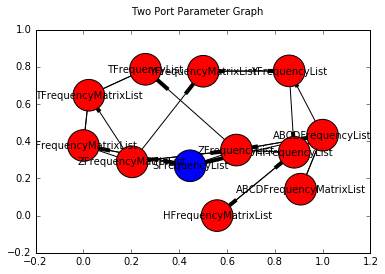

In [62]:
new_graph.show()

In [63]:
new_graph.move_to_node("ZFrequencyList")

['edge_SFrequencyList_ZFrequencyList_000']
moving SFrequencyList -> ZFrequencyList


In [64]:
new_graph.data

[[1.0,
  (105.52594171997156+0j),
  242.09310589907608,
  242.09310589907608,
  (105.52594171997156+0j)]]